In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 在原有的 9 个物种基础上添加第 10 个物种“蝙蝠 (Ba)”，只捕食蝗虫 (L)。
def fret_func(x,t):
    if x <= 0.5:
        return (1 + 1.6* x**2)*np.exp(-t/200)  # 递增部分
    else:
        return 1.4 * np.exp(-10 * (x - 0.5))*np.exp(-t/200)
def rosenzweig_macarthur_with_bacteria_tree_bat(t, y, params):
    """
    修改版生态系统动力学模型，包含 10 个物种：
    R (水稻), W (稗草), M (鼠), L (蝗虫), S (蛇),
    Sp (蜘蛛), E (鹰), B (细菌), T (树), Ba (蝙蝠).
    Ba 只捕食 L。
    """
    # 解包状态变量
    R, W, M, L, S, Sp, E, B_, T_, Ba = y

    (
        # ------------------- 原有参数 -------------------
        rR, KR, rW, KW,
        aRM, bRM, eMR, aWM, bWM, eMW,
        aRL, bRL, eLR, aWL, bWL, eLW,
        aSM, bSM, eSM, aSL, bSL, eSL,
        aSpL, bSpL, eSpL,
        aES, bES, eES, aESp, bESp, eESp, aEM, bEM, eEM,
        aBR, bBR, eRB, aBW, bBW, eWB,
        alphaB, dR, dW, dM, dL, dS, dSp, dE, dB,
        rT, KT, aTM, bTM, eTM, aTL, bTL, eTL, dT,
        # ------------------- 新增蝙蝠相关参数 -------------------
        aBaL, bBaL, eBaL, dBa,
        fret # 肥料参数
    ) = params
    bat_par=[0.01, 0.01, 0.01]
    #------------------- 与原有物种相关的计算 -------------------
    # 1) 水稻 R
    cons_R_by_M = (aRM * R * M) / (1.0 + bRM * R)
    cons_R_by_L = (aRL * R * L) / (1.0 + bRL * R)
    cons_B_by_R = (aBR * B_ * R) / (1.0 + bBR * B_)
    gain_R_from_B = eRB * cons_B_by_R
    #  蝙蝠的影响, 肥料的影响
    rR+=bat_par[0]*Ba*fret_func(x=fret,t=t)
    dRdt = rR * R * (1 - R / KR) + gain_R_from_B - cons_R_by_M - cons_R_by_L - dR * R

    # 2) 稗草 W
    cons_W_by_M = (aWM * W * M) / (1.0 + bWM * W)
    cons_W_by_L = (aWL * W * L) / (1.0 + bWL * W)
    cons_B_by_W = (aBW * B_ * W) / (1.0 + bBW * B_)
    gain_W_from_B = eWB * cons_B_by_W
    #  蝙蝠的影响
    rW+=bat_par[1]*Ba*fret_func(x=fret,t=t)
    dWdt = rW * W * (1 - W / KW) + gain_W_from_B - cons_W_by_M - cons_W_by_L - dW * W

    # 3) 树 T
    cons_T_by_M = (aTM * T_ * M) / (1.0 + bTM * T_)
    cons_T_by_L = (aTL * T_ * L) / (1.0 + bTL * T_)
    gain_M_from_T = eTM * cons_T_by_M
    gain_L_from_T = eTL * cons_T_by_L
    #  蝙蝠的影响
    rT+=bat_par[2]*Ba*fret_func(x=fret,t=t)
    dTdt = rT * T_ * (1 - T_ / KT) - cons_T_by_M - cons_T_by_L - dT * T_

    # 4) 鼠 M
    gain_M_from_R = eMR * cons_R_by_M
    gain_M_from_W = eMW * cons_W_by_M
    cons_M_by_S = (aSM * M * S) / (1.0 + bSM * M)
    cons_M_by_E = (aEM * M * E) / (1.0 + bEM * M)
    dMdt = gain_M_from_R + gain_M_from_W + gain_M_from_T - cons_M_by_S - cons_M_by_E - dM * M

    # 5) 蝗虫 L
    gain_L_from_R = eLR * cons_R_by_L
    gain_L_from_W = eLW * cons_W_by_L
    cons_L_by_S = (aSL * L * S) / (1.0 + bSL * L)
    cons_L_by_Sp = (aSpL * L * Sp) / (1.0 + bSpL * L)
    # 蝙蝠捕食蝗虫
    cons_L_by_Ba = (aBaL * L * Ba) / (1.0 + bBaL * L)
    dLdt = (gain_L_from_R + gain_L_from_W + gain_L_from_T
            - cons_L_by_S - cons_L_by_Sp
            - cons_L_by_Ba
            - dL * L)

    # 6) 蛇 S
    gain_S_from_M = eSM * cons_M_by_S
    gain_S_from_L = eSL * cons_L_by_S
    cons_S_by_E = (aES * S * E) / (1.0 + bES * S)
    dSdt = gain_S_from_M + gain_S_from_L - cons_S_by_E - dS * S

    # 7) 蜘蛛 Sp
    gain_Sp_from_L = eSpL * cons_L_by_Sp
    cons_Sp_by_E = (aESp * Sp * E) / (1.0 + bESp * Sp)
    dSpdt = gain_Sp_from_L - cons_Sp_by_E - dSp * Sp

    # 8) 鹰 E
    gain_E_from_S = eES * cons_S_by_E
    gain_E_from_Sp = eESp * cons_Sp_by_E
    gain_E_from_M = eEM * cons_M_by_E
    dEdt = gain_E_from_S + gain_E_from_Sp + gain_E_from_M - dE * E

    # 9) 细菌 B
    total_death_flux = (
        dR * R + dW * W + dM * M +
        dL * L + dS * S + dSp * Sp +
        dE * E + dT * T_
    )
    bacteria_growth = alphaB * total_death_flux
    dBdt = bacteria_growth - dB * B_

    # 10) 蝙蝠 Ba
    # 仅捕食蝗虫，获得能量
    gain_Ba_from_L = eBaL * cons_L_by_Ba
    # 自然死亡率 dBa
    dBadt = gain_Ba_from_L - dBa * Ba

    return [dRdt, dWdt, dMdt, dLdt, dSdt, dSpdt, dEdt, dBdt, dTdt, dBadt]


def generate_value_bat(pars, init_val, t_end, points_interval):
    t_span = (0, t_end)
    t_eval = np.arange(0, t_end, points_interval)
    sol = solve_ivp(rosenzweig_macarthur_with_bacteria_tree_bat,
                    t_span, init_val, args=(pars,),
                    t_eval=t_eval, method='RK45')
    return sol


def my_plot_bat(sol):
    """ 在图表中包含新加入的蝙蝠 (Ba) 种群 """
    plt.rcParams['font.family'] = 'SimHei'
    plt.figure(figsize=(12, 8))
    plt.xlabel('时间')
    plt.ylabel('种群数量 / 浓度')
    plt.title('Rosenzweig-MacArthur 生态系统模型（含细菌、树、蝙蝠）')

    labels = [
        '水稻 (R)', '稗草 (W)', '鼠 (M)', '蝗虫 (L)', '蛇 (S)',
        '蜘蛛 (Sp)', '鹰 (E)', '细菌 (B)', '树 (T)', '蝙蝠 (Ba)'
    ]
    for i, label in enumerate(labels):
        plt.plot(sol.t, sol.y[i], label=label)

    plt.legend()
    plt.show()
def my_plot_yt(y,t):
    plt.rcParams['font.family'] = 'SimHei'
    plt.figure(figsize=(12, 8))
    plt.xlabel('时间')
    plt.ylabel('种群数量 / 浓度')
    plt.title('Rosenzweig-MacArthur 生态系统模型（含细菌、树、蝙蝠）')
    labels = [
        '水稻 (R)', '稗草 (W)', '鼠 (M)', '蝗虫 (L)', '蛇 (S)',
        '蜘蛛 (Sp)', '鹰 (E)', '细菌 (B)', '树 (T)', '蝙蝠 (Ba)'
    ]
    for i, label in enumerate(labels):
        plt.plot(t, y[i], label=label)
    plt.legend()
    plt.show()

In [5]:

# 示例参数配置说明：
# - 前 52 个参数与之前模型一致，最后 4 个是蝙蝠相关参数：
#   aBaL, bBaL, eBaL, dBa
example_params_with_bat = (
    0.3, 200,        # rR, KR
    0.3, 200,        # rW, KW
    0.001, 0.001, 0.2,  # aRM, bRM, eMR
    0.001, 0.001, 0.2,  # aWM, bWM, eMW
    0.001, 0.001, 0.2,  # aRL, bRL, eLR
    0.001, 0.001, 0.2,  # aWL, bWL, eLW
    0.005, 0.005, 0.2,  # aSM, bSM, eSM
    0.001, 0.001, 0.2,  # aSL, bSL, eSL
    0.001, 0.001, 0.2,  # aSpL, bSpL, eSpL
    0.001, 0.001, 0.2,  # aES, bES, eES
    0.001, 0.001, 0.2,  # aESp, bESp, eESp
    0.001, 0.001, 0.2,  # aEM, bEM, eEM
    0.001, 0.001, 0.1,  # aBR, bBR, eRB
    0.001, 0.001, 0.1,  # aBW, bBW, eWB
    0.01,               # alphaB
    0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,  # dR, dW, dM, dL, dS, dSp, dE, dB
    0.3, 200,          # rT, KT
    0.0005, 0.001, 0.2,  # aTM, bTM, eTM
    0.0005, 0.001, 0.2,  # aTL, bTL, eTL
    0.01,               # dT
    # ---------- 蝙蝠新参数 ----------
    0.001, 0.001, 0.25, 0.01,0.1  # aBaL, bBaL, eBaL, dBa
)

# # 初始值增加蝙蝠（Ba），其余与之前类似
# # R, W, M, L, S, Sp, E, B, T, Ba
# init_val_bat = [0, 50, 10, 15, 5, 5, 3, 10, 50, 2]
#
# # 运行示例
# if __name__ == "__main__":
#     sol_bat = generate_value_bat(example_params_with_bat, init_val_bat, 400, 0.001)
#     my_plot_bat(sol_bat)

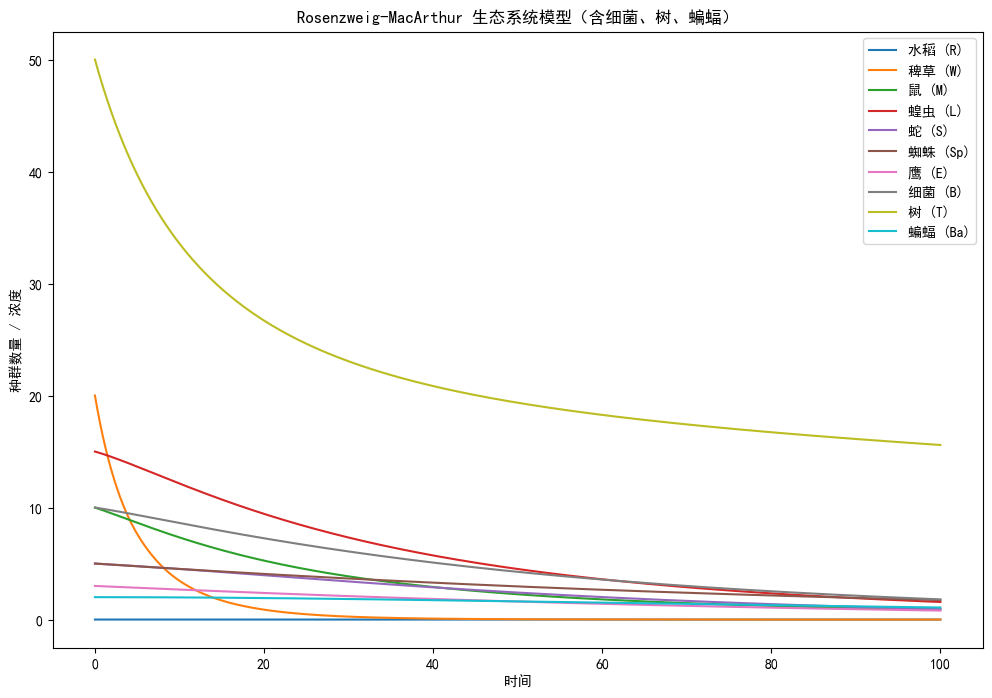

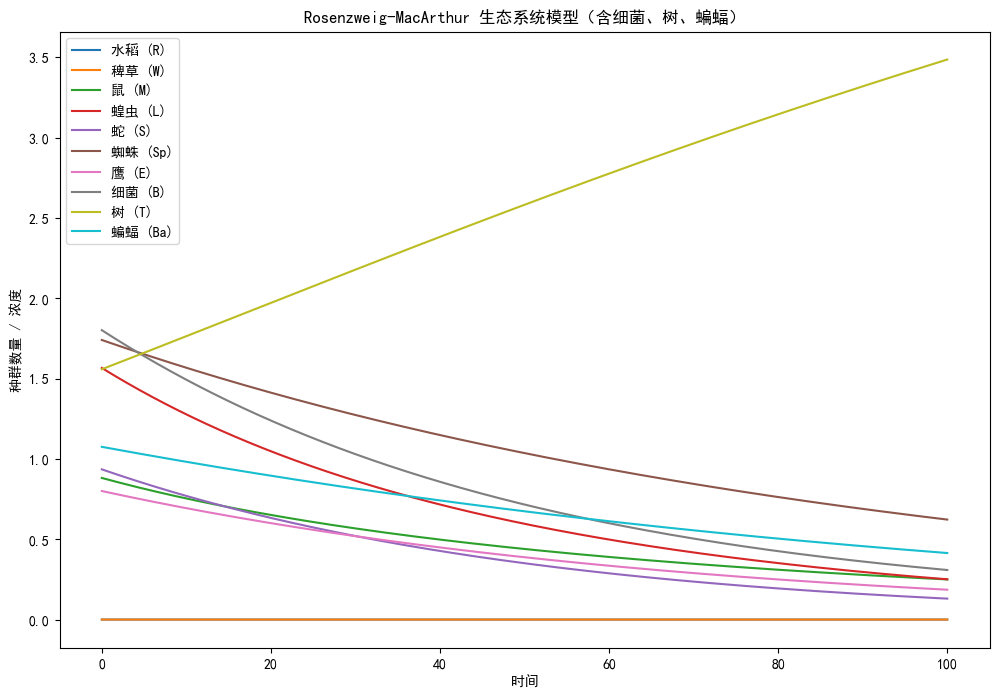

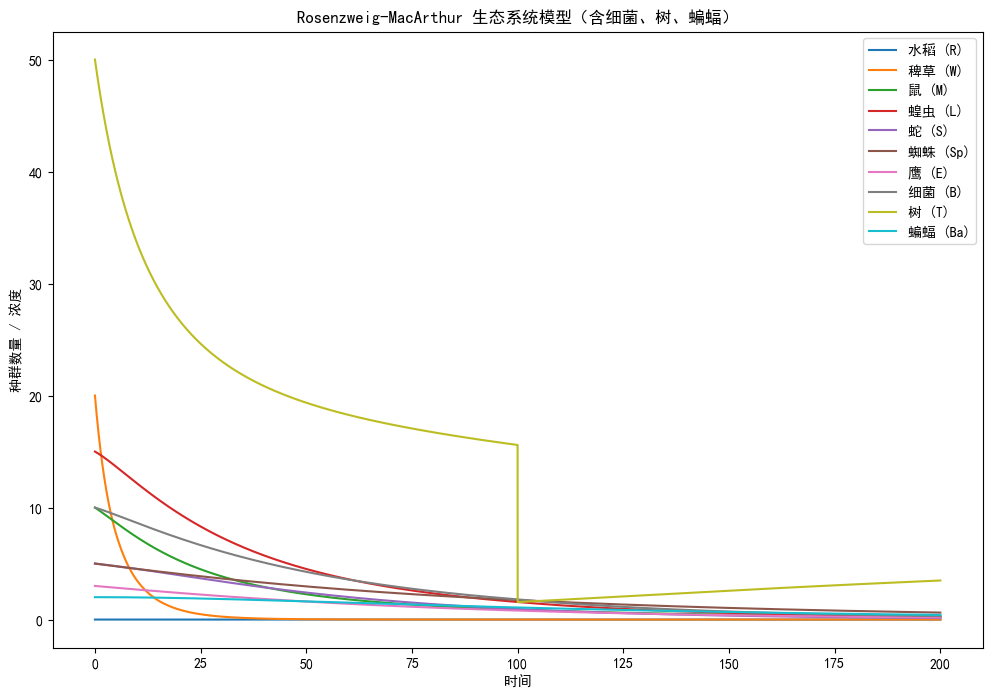

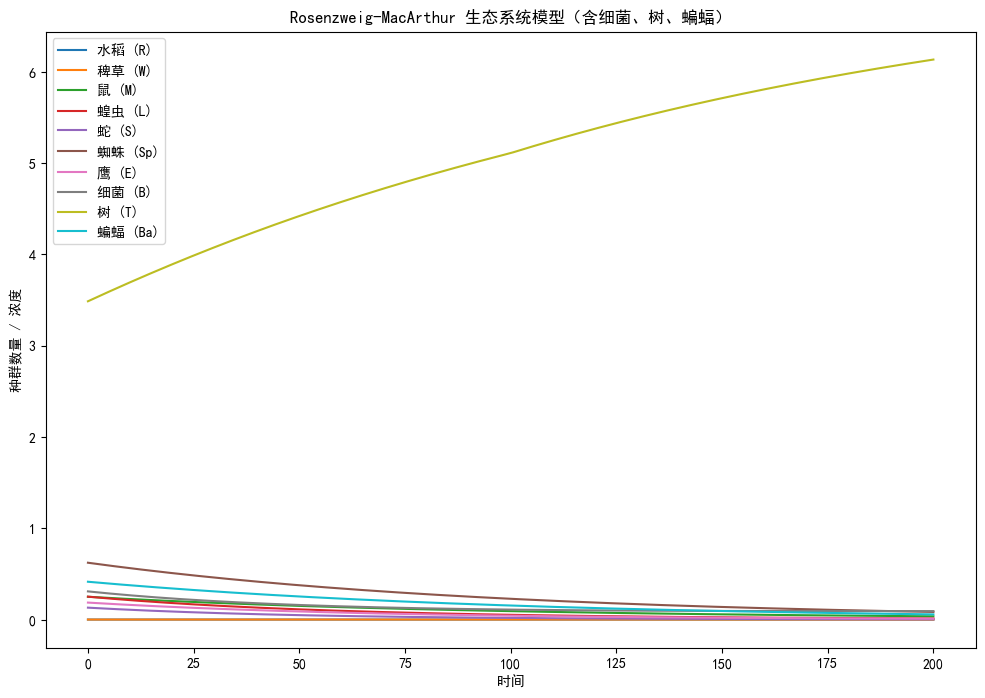

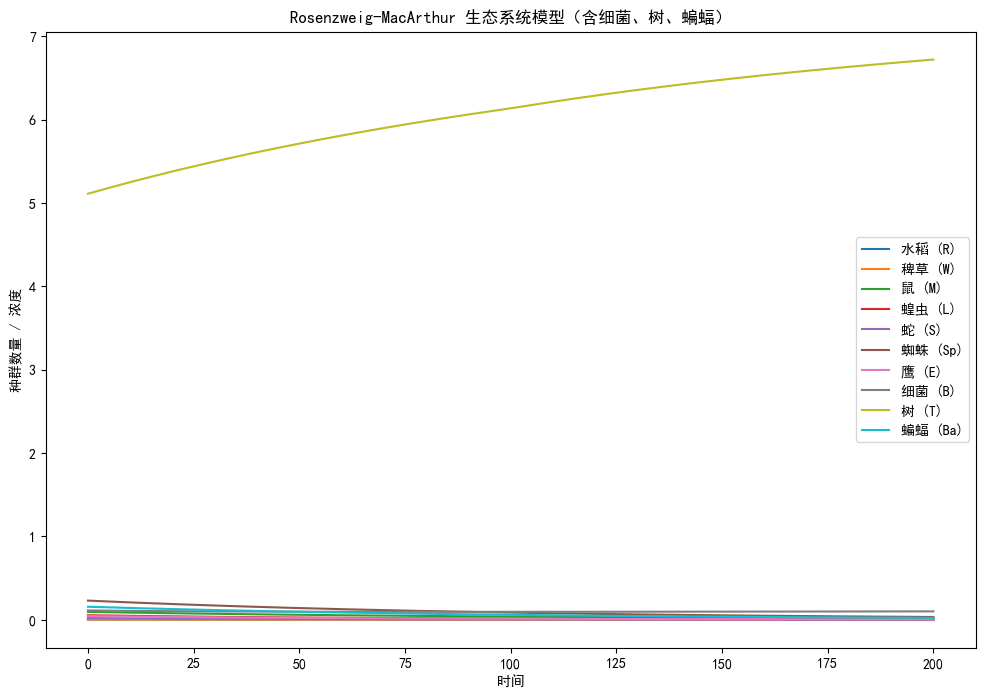

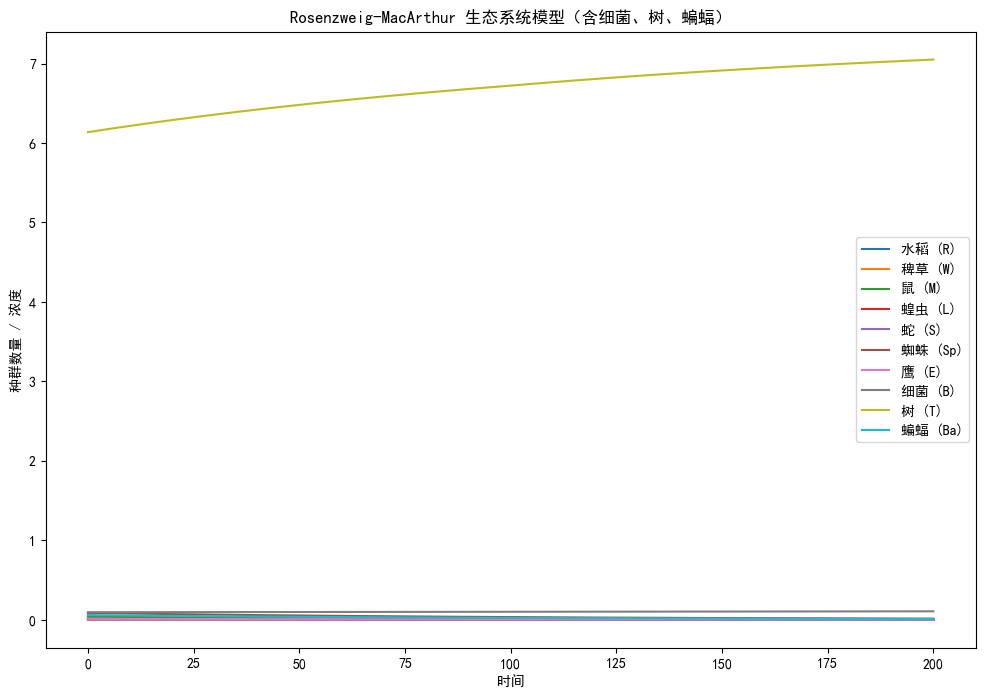

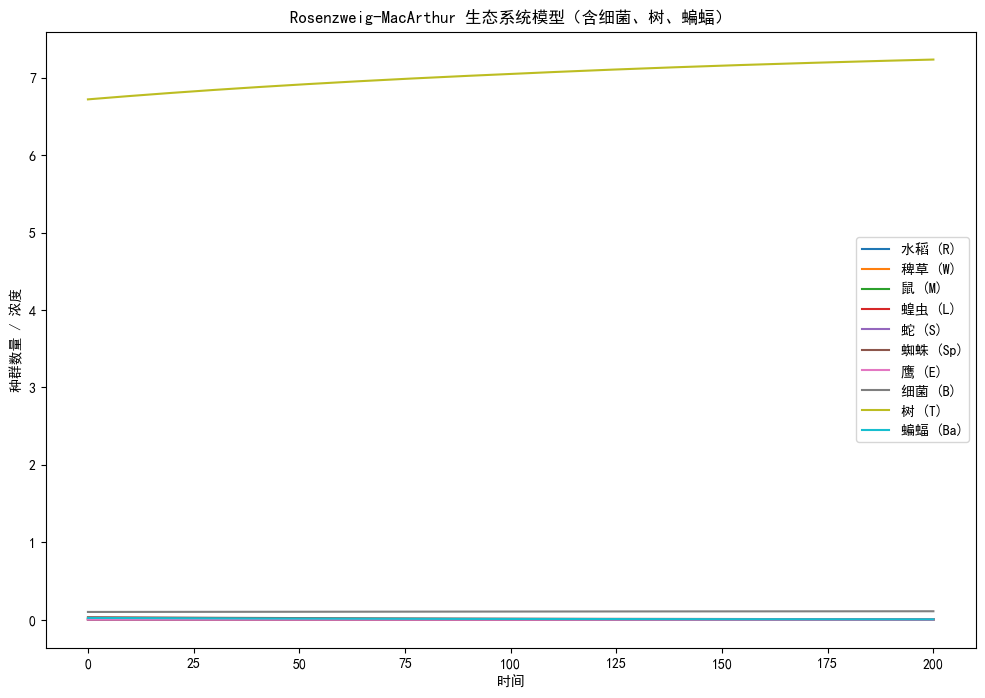

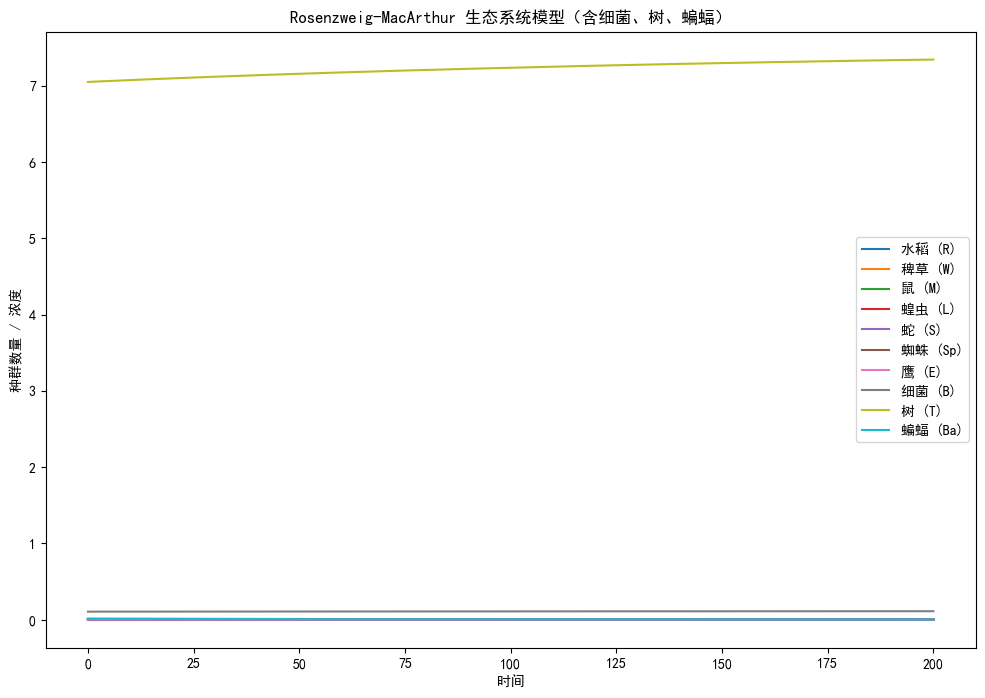

In [18]:
# 从森林到农田
def from_forest():
    pass
    par = (
        0.05, 300,       # rR, KR
        0.05, 20,       # rW, KW
        # 提高捕食速率，舉例: aRM=0.007, aRL=0.007, aSM=0.006
        0.004, 0.001, 0.2,
        0.003, 0.001, 0.2,
        0.004, 0.001, 0.2,
        0.003, 0.001, 0.2,
        0.006, 0.005, 0.2,
        0.001, 0.001, 0.2,
        0.001, 0.001, 0.2,
        0.001, 0.001, 0.2,
        0.001, 0.001, 0.2,
        0.001, 0.001, 0.2,
        0.001, 0.001, 0.1,
        0.001, 0.001, 0.1,
        0.02,                # alphaB
        0.02, 0.015, 0.01, 0.015, 0.02, 0.01, 0.015, 0.02,  # dR, dW, dM, dL, dS, dSp, dE, dB
        0.02, 30,           # rT, KT
        0.0005, 0.001, 0.2,
        0.0005, 0.001, 0.2,
        0.015,               # dT
        0.003, 0.001, 0.22, 0.01,  # aBaL, bBaL, eBaL, dBa
        0.2                  # 额外参数
    )
    init_val0=[0, 20, 10, 15, 5, 5, 3, 10, 50, 2]
    sol_0=generate_value_bat(par, init_val0, 100, 0.01) # 200
    my_plot_bat(sol_0)
    # t:0-200: 原始森林
    # t:200-300:开垦
    # t:300-500:第一次收割
    # 此后每200一次循环
    # 开垦
    tree_rate=0.1
    grass_rate=0.1
    stage2_init0=sol_0.y[:,-1]
    stage2_init0[8]*=tree_rate
    stage2_init0[0]=20
    stage2_init0[1]*=grass_rate
    par_stage2=list(par)
    par_stage2[-1]=0.1
    sol_stage2=generate_value_bat(par_stage2, stage2_init0,100, 0.01)
    my_plot_bat(sol_stage2)
    y12=np.hstack((sol_0.y, sol_stage2.y))
    t12=np.arange(0,200,0.01)
    my_plot_yt(y12,t12)
    # 收割
    sim_num=5
    stage_3_init=sol_stage2.y[:,-1]
    stage_3_init[0]=0
    for idx in range(sim_num):
        sol_stage3=generate_value_bat(par_stage2, stage_3_init, 100,0.01)
        # my_plot_bat(sol_stage3)
        stage_3_init=sol_stage3.y[:,-1]
        stage_3_init[0]=20
        sol_stage4=generate_value_bat(par_stage2, stage_3_init, 100,0.01)
        # my_plot_bat(sol_stage4)
        yy=np.hstack((sol_stage3.y, sol_stage4.y))
        tt=np.arange(0,200,0.01)
        my_plot_yt(yy,tt)
        stage_3_init[0]=0
from_forest()

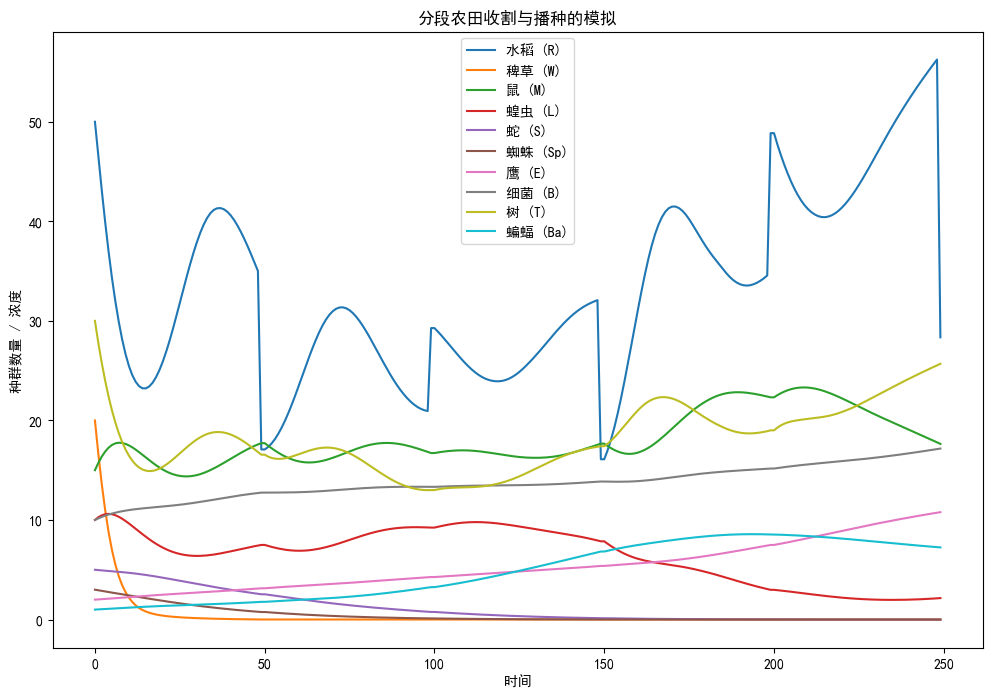

In [19]:

from scipy.integrate import solve_ivp

# ---------------------------
# 已在提问中给出的函数和模型:
# rosenzweig_macarthur_with_bacteria_tree_bat(...)
# generate_value_bat(...)
# my_plot_bat(...)
# my_plot_yt(...)
# ---------------------------
# 在此省略，假设它们已定义完毕

def simulate_harvest_and_reseed(
    initial_values,             # 初始种群数量，用长度为10的列表或数组表示
    params,                     # 模型参数
    T_interval,                 # 每个阶段的长度
    num_cycles=5,               # 重复播种收割的次数
    points_interval=0.5,        # 数值积分时的步进
    harvest_factor=(0.8, 0.8),  # 收割时对 (R, W) 的影响系数
    reseed_factor=(1.2, 1.1)    # 播种时对 (R, W) 的影响系数
):
    """
    模拟农田在每个时间间隔 T_interval 后被收割，接着在下一个 T_interval 结束后重新播种。
    - harvest_factor: 收割时对 (水稻 R, 稗草 W) 的缩放因子 (例如 (0.8, 0.8) 表示减少 20%)
    - reseed_factor : 播种时对 (水稻 R, 稗草 W) 的增量或缩放因子
    """
    # 用于记录分段仿真结果
    all_t = []
    all_y = []

    state_current = np.array(initial_values, dtype=float)
    current_time = 0.0

    for cycle in range(num_cycles):
        # 1) 从 current_time 到 current_time + T_interval，模拟收割/播种前的阶段
        t_span = (current_time, current_time + T_interval)
        t_eval = np.arange(current_time, current_time + T_interval, points_interval)

        # 假设 generate_value_bat 可以传入起始时间, 这里在参数上稍作适配:
        def ode_wrapper(t, y):
            # 为了保持与现有模型兼容，t 需要从 0 开始计时
            # 这里将 t_shift = t - current_time，再传给 rosenzweig_macarthur_with_bacteria_tree_bat
            return rosenzweig_macarthur_with_bacteria_tree_bat(
                t - current_time, y, params
            )

        sol = solve_ivp(ode_wrapper, t_span, state_current, t_eval=t_eval, method='RK45')

        # 记录本阶段的结果
        all_t.extend(sol.t)
        all_y.append(sol.y)

        # 将末尾时刻的状态作为下一阶段的初始值
        state_current = sol.y[:, -1]
        current_time += T_interval

        # 2) 进行一次收割或播种操作
        # 在示例中，假设奇数周期做收割，偶数周期做播种 (可按实际需求调整)
        # cycle 从 0 开始计数，cycle=0 表示第一次循环
        if cycle % 2 == 0:
            # 收割：降低 R, W 等
            state_current[0] *= harvest_factor[0]  # R
            state_current[1] *= harvest_factor[1]  # W
            # 树 (T) 在最初已大幅减少，不一定再次人为清除，故此处可不处理 T
        else:
            # 播种：提高 R, W
            state_current[0] *= reseed_factor[0]
            state_current[1] *= reseed_factor[1]
            # 不再次清除稗草与树，仅增加水稻、稗草

    # 拼接所有仿真结果
    all_y = np.hstack(all_y)
    all_t = np.array(all_t)
    return all_t, all_y

# ---------------------------
# 以下示例展示如何调用以上函数并绘图
if __name__ == "__main__":
    # 初始状态示例 (R, W, M, L, S, Sp, E, B, T, Ba)
    initial_vals = [
        50.0,  20.0, # R, W
        15.0,  10.0, # M, L
        5.0,   3.0,  # S, Sp
        2.0,   10.0, # E, B
        30.0,  1.0   # T, Ba
    ]

    # 参数示例，需与 rosenzweig_macarthur_with_bacteria_tree_bat 中解包顺序对齐
    # 这里只是示意，实际要填入合理的数值
    sample_params = (
        0.5, 100, 0.3, 80,      # rR, KR, rW, KW
        0.02, 0.01, 0.1, 0.02, 0.01, 0.1, # aRM, bRM, eMR, aWM, bWM, eMW (示意)
        0.02, 0.01, 0.1, 0.02, 0.01, 0.1, # aRL, bRL, eLR, aWL, bWL, eLW
        0.01, 0.01, 0.1, 0.01, 0.01, 0.1, # aSM, bSM, eSM, aSL, bSL, eSL
        0.01, 0.01, 0.1,                 # aSpL, bSpL, eSpL
        0.01, 0.01, 0.1, 0.01, 0.01, 0.1,# aES, bES, eES, aESp, bESp, eESp
        0.01, 0.01, 0.1,                 # aEM, bEM, eEM
        0.02, 0.01, 0.1, 0.02, 0.01, 0.1,# aBR, bBR, eRB, aBW, bBW, eWB
        0.2,                             # alphaB
        0.01, 0.01, 0.01, 0.01, 0.01,    # dR, dW, dM, dL, dS
        0.01, 0.01, 0.01,               # dSp, dE, dB
        0.3, 50, 0.01, 0.01, 0.1,       # rT, KT, aTM, bTM, eTM
        0.01, 0.01, 0.1, 0.01,          # aTL, bTL, eTL, dT
        # ------ 蝙蝠相关参数 ------
        0.01, 0.01, 0.3, 0.01,          # aBaL, bBaL, eBaL, dBa
        0.0                              # fret (肥料参数, 此处示意为 0)
    )

    # 模拟的T间隔 (时间单位) 和重复次数
    T_int = 50
    cycles = 5

    # 获取分段仿真结果
    t_result, y_result = simulate_harvest_and_reseed(
        initial_vals,
        sample_params,
        T_int,
        num_cycles=cycles,
        points_interval=1.0,     # 每1个时间单位记录一次结果
        harvest_factor=(0.5, 0.5), # 收割时对 R, W 的缩放因子 (示例减少 50%)
        reseed_factor=(1.4, 1.2)   # 播种时对 R, W 的缩放因子 (示例增大)
    )

    # 绘图
    plt.rcParams['font.family'] = 'SimHei'
    plt.figure(figsize=(12, 8))
    plt.xlabel('时间')
    plt.ylabel('种群数量 / 浓度')
    plt.title('分段农田收割与播种的模拟')

    labels = [
        '水稻 (R)', '稗草 (W)', '鼠 (M)', '蝗虫 (L)', '蛇 (S)',
        '蜘蛛 (Sp)', '鹰 (E)', '细菌 (B)', '树 (T)', '蝙蝠 (Ba)'
    ]

    for i, label in enumerate(labels):
        plt.plot(t_result, y_result[i], label=label)

    plt.legend()
    plt.show()

In [7]:
"""
生态系统动力学模型，包含 9 个物种

参数说明:
rR, KR  - 水稻 (R) 的增长率和环境承载能力
rW, KW  - 稗草 (W) 的增长率和环境承载能力
aRM, bRM, eMR - 鼠 (M) 捕食水稻 (R) 的速率、抑制系数和转换效率
aWM, bWM, eMW - 鼠 (M) 捕食稗草 (W) 的速率、抑制系数和转换效率
aRL, bRL, eLR - 蝗虫 (L) 捕食水稻 (R) 的速率、抑制系数和转换效率
aWL, bWL, eLW - 蝗虫 (L) 捕食稗草 (W) 的速率、抑制系数和转换效率
aSM, bSM, eSM - 蛇 (S) 捕食鼠 (M) 的速率、抑制系数和转换效率
aSL, bSL, eSL - 蛇 (S) 捕食蝗虫 (L) 的速率、抑制系数和转换效率
aSpL, bSpL, eSpL - 蜘蛛 (Sp) 捕食蝗虫 (L) 的速率、抑制系数和转换效率
aES, bES, eES - 鹰 (E) 捕食蛇 (S) 的速率、抑制系数和转换效率
aESp, bESp, eESp - 鹰 (E) 捕食蜘蛛 (Sp) 的速率、抑制系数和转换效率
aEM, bEM, eEM - 鹰 (E) 捕食鼠 (M) 的速率、抑制系数和转换效率
aBR, bBR, eRB - 细菌 (B) 分解水稻 (R) 的速率、抑制系数和增长效应
aBW, bBW, eWB - 细菌 (B) 分解稗草 (W) 的速率、抑制系数和增长效应
alphaB - 细菌 (B) 通过分解死亡物种的增长率
dR, dW, dM, dL, dS, dSp, dE, dB - 各物种的自然死亡率
rT, KT - 树 (T) 的增长率和环境承载能力
aTM, bTM, eTM - 鼠 (M) 捕食树 (T) 的速率、抑制系数和转换效率
aTL, bTL, eTL - 蝗虫 (L) 捕食树 (T) 的速率、抑制系数和转换效率
dT - 树 (T) 的自然死亡率
"""

'\n生态系统动力学模型，包含 9 个物种\n\n参数说明:\nrR, KR  - 水稻 (R) 的增长率和环境承载能力\nrW, KW  - 稗草 (W) 的增长率和环境承载能力\naRM, bRM, eMR - 鼠 (M) 捕食水稻 (R) 的速率、抑制系数和转换效率\naWM, bWM, eMW - 鼠 (M) 捕食稗草 (W) 的速率、抑制系数和转换效率\naRL, bRL, eLR - 蝗虫 (L) 捕食水稻 (R) 的速率、抑制系数和转换效率\naWL, bWL, eLW - 蝗虫 (L) 捕食稗草 (W) 的速率、抑制系数和转换效率\naSM, bSM, eSM - 蛇 (S) 捕食鼠 (M) 的速率、抑制系数和转换效率\naSL, bSL, eSL - 蛇 (S) 捕食蝗虫 (L) 的速率、抑制系数和转换效率\naSpL, bSpL, eSpL - 蜘蛛 (Sp) 捕食蝗虫 (L) 的速率、抑制系数和转换效率\naES, bES, eES - 鹰 (E) 捕食蛇 (S) 的速率、抑制系数和转换效率\naESp, bESp, eESp - 鹰 (E) 捕食蜘蛛 (Sp) 的速率、抑制系数和转换效率\naEM, bEM, eEM - 鹰 (E) 捕食鼠 (M) 的速率、抑制系数和转换效率\naBR, bBR, eRB - 细菌 (B) 分解水稻 (R) 的速率、抑制系数和增长效应\naBW, bBW, eWB - 细菌 (B) 分解稗草 (W) 的速率、抑制系数和增长效应\nalphaB - 细菌 (B) 通过分解死亡物种的增长率\ndR, dW, dM, dL, dS, dSp, dE, dB - 各物种的自然死亡率\nrT, KT - 树 (T) 的增长率和环境承载能力\naTM, bTM, eTM - 鼠 (M) 捕食树 (T) 的速率、抑制系数和转换效率\naTL, bTL, eTL - 蝗虫 (L) 捕食树 (T) 的速率、抑制系数和转换效率\ndT - 树 (T) 的自然死亡率\n'

In [8]:
# 从森林到农田
"""
什么条件会影响K值?
土壤营养条件
光照条件
种植密度(作物的初始种群密度)
"""

'\n什么条件会影响K值?\n土壤营养条件\n光照条件\n种植密度(作物的初始种群密度)\n'